### Лабораторная работа №1: **Классификация текстов на основе TF-IDF и Naive Bayes**

#### Теоретическая часть

**TF-IDF (Term Frequency-Inverse Document Frequency)** – это метод взвешивания терминов в текстовом документе, который оценивает важность термина пропорционально тому, сколько раз этот термин встречается в конкретном документе, но обратно пропорционально частоте встречаемости этого термина во всем корпусе документов. Таким образом, редкие термины получают больший вес, чем частые.

**Naive Bayes** – это простой классификатор, основанный на байесовской теореме. Он предполагает независимость признаков, что делает его быстрым и эффективным для многих задач классификации текстов.

#### Практическая задача

Используя корпус данных новостей, выполните следующую последовательность шагов:

1. Загрузите и предобработайте данные: удалите стоп-слова, проведите лемматизацию/стемминг, преобразуйте все буквы в нижний регистр.
2. Создайте матрицу TF-IDF для вашего набора данных.
3. Разделите данные на тренировочный и тестовый наборы.
4. Постройте модель Naive Bayes на основе тренировочного набора.
5. Проверьте точность модели на тестовом наборе.
6. Проанализируйте результаты и сделайте выводы о качестве классификации.

#### Указания по выполнению

1. Используйте библиотеку `sklearn` для реализации TF-IDF и Naive Bayes.
2. Выберите подходящий корпус данных, например, новостные статьи или отзывы.
3. Проведите сравнительный анализ различных параметров модели (количество признаков, пороговые значения и т.д.) и выберите оптимальный вариант.
4. Подготовьте отчет, включающий код, графики и таблицы с результатами экспериментов.

In [41]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import optuna
import optuna.visualization as vis
from IPython.display import clear_output
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Загрузите и предобработайте данные: удалите стоп-слова, проведите лемматизацию/стемминг, преобразуйте все буквы в нижний регистр.

In [42]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet') 

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /home/danya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/danya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/danya/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/danya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [43]:
def preprocess(text):
    filtered_tokens = filter(
    lambda word: lemmatizer.lemmatize(word) not in string.punctuation and word not in stop_words,
    nltk.word_tokenize(text.lower())
    )

    return list(filtered_tokens)

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

news = [' '.join(preprocess(doc)) for doc in newsgroups.data]
len(news), news[0]

(18846,
 'sure bashers pens fans pretty confused lack kind posts recent pens massacre devils actually bit puzzled bit relieved however going put end non-pittsburghers relief bit praise pens man killing devils worse thought jagr showed much better regular season stats also lot fo fun watch playoffs bowman let jagr lot fun next couple games since pens going beat pulp jersey anyway disappointed see islanders lose final regular season game pens rule')

### 2. Создайте матрицу TF-IDF для вашего набора данных.


In [44]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(news)
tfidf_matrix.shape

(18846, 134376)

### 3. Разделите данные на тренировочный и тестовый наборы.


In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_matrix, newsgroups.target, test_size=0.2, stratify=newsgroups.target, random_state=0
)

X_train.shape, X_test.shape

((15076, 134376), (3770, 134376))

### 4. Постройте модель Naive Bayes на основе тренировочного набора.


In [46]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

### 5. Проверьте точность модели на тестовом наборе.


In [47]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7259946949602122

In [48]:
def objective(trial):
    max_features = trial.suggest_categorical('max_features', [None, 1000, 5000, 10000])
    alpha = trial.suggest_float('alpha', 0.1, 1.0)
    
    vectorizer = TfidfVectorizer(max_features=max_features)
    X_tfidf = vectorizer.fit_transform(news)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, newsgroups.target, test_size=0.2, stratify=newsgroups.target, random_state=0
    )
    
    model = MultinomialNB(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    clear_output()
    return acc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

fig = vis.plot_optimization_history(study)
fig.show()

trials_df = study.trials_dataframe()

[I 2025-03-28 02:12:38,386] Trial 99 finished with value: 0.7326259946949603 and parameters: {'max_features': None, 'alpha': 0.6930130140840354}. Best is trial 51 with value: 0.7676392572944297.


In [49]:
trials_df[['number', 'value','params_max_features', 'params_alpha']].sort_values('value', ascending=False)

,number,value,params_max_features,params_alpha
82,82,0.767639,NaN,0.102971
84,84,0.767639,NaN,0.100877
74,74,0.767639,NaN,0.100859
59,59,0.767639,NaN,0.101491
72,72,0.767639,NaN,0.100593
...,...,...,...,...
0,0,0.568700,1000.0,0.101696
28,28,0.568435,1000.0,0.253105
49,49,0.568170,1000.0,0.204889
36,36,0.567905,1000.0,0.239351


### 6. Проанализируйте результаты и сделайте выводы о качестве классификации.


In [50]:
best_params = study.best_trial.params

vectorizer_best = TfidfVectorizer(max_features=best_params['max_features'])
X_tfidf_best = vectorizer_best.fit_transform(news)
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf_best, newsgroups.target, test_size=0.2, stratify=newsgroups.target, random_state=0
)
best_model = MultinomialNB(alpha=best_params['alpha'])
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.51      0.63       160
           1       0.77      0.78      0.77       195
           2       0.78      0.71      0.74       197
           3       0.71      0.77      0.74       196
           4       0.86      0.77      0.81       193
           5       0.87      0.85      0.86       198
           6       0.82      0.79      0.81       195
           7       0.86      0.80      0.83       198
           8       0.89      0.82      0.86       199
           9       0.92      0.84      0.88       199
          10       0.59      0.90      0.72       200
          11       0.73      0.82      0.77       198
          12       0.79      0.69      0.74       197
          13       0.92      0.83      0.87       198
          14       0.83      0.82      0.82       197
          15       0.53      0.94      0.68       199
          16       0.66      0.81      0.72       182
          17       0.83    

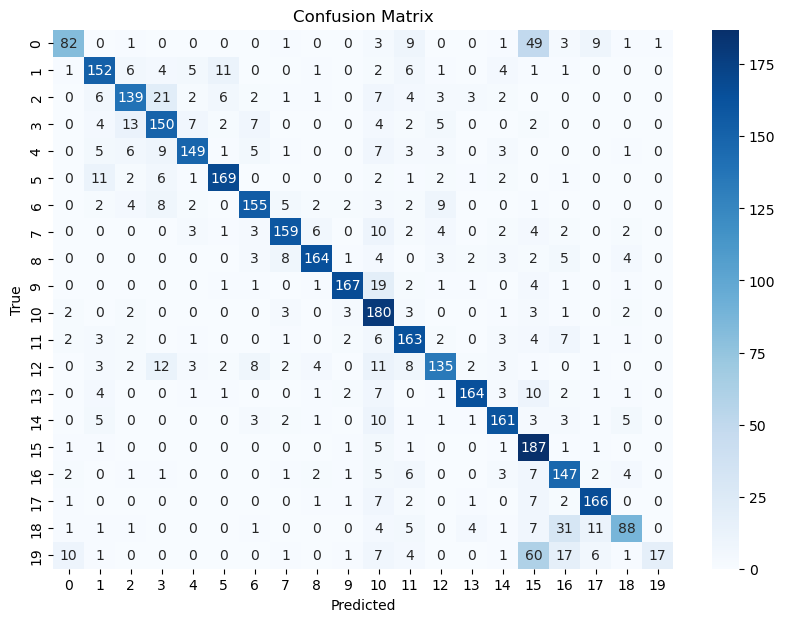

In [51]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()